In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

from cfollmer.objectives import log_g, relative_entropy_control_cost
from cfollmer.sampler_utils import FollmerSDE
import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

## Generating Toy 2D Dataset.

In [2]:
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"
random_state = 170

X, y = make_blobs(n_samples=100,
                  cluster_std=[0.2, 0.2, 0.2],
                  random_state=random_state)

# X = X[y==0,:]
# y = y[y==0]
# # Scale data to have mean 0 and variance 1 
# # which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)


X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

In [3]:
y

array([0, 2, 2, 0, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 2, 2,
       2, 2, 1, 1, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       0, 1, 2, 2, 0, 1, 2, 2, 1, 2, 0, 1, 2, 1, 0, 0, 1, 0, 0, 2, 0, 2,
       2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 2,
       2, 1, 2, 2, 1, 0, 2, 2, 0, 0, 0, 2])

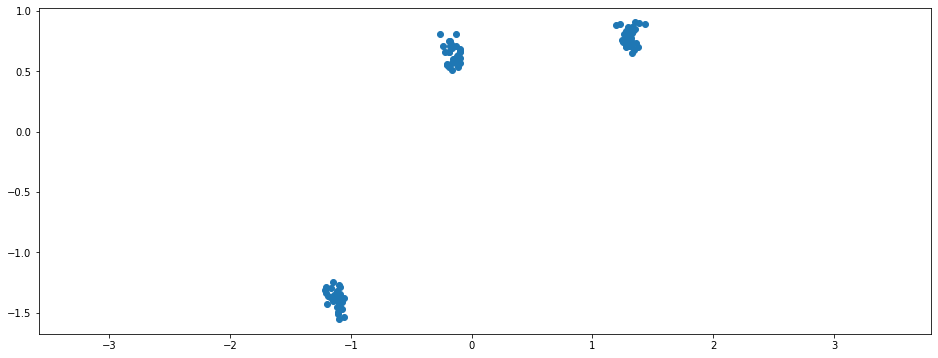

In [4]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

ax1.plot(X_scaled[:, 0], X_scaled[:, 1], 
         linestyle='none', 
         marker='o')

ax1.axis('equal');

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}

To do so we use the EM discretisation.

In [5]:
def log_gaussian(x, mean=0):
    """
    Returns the density of x under the supplied gaussian. Defaults to
    standard gaussian N(0, I)
    :param x: (*) torch.Tensor
    :param mean: float or torch.FloatTensor with dimensions (*)
    :param logvar: float or torch.FloatTensor with dimensions (*)
    :return: (*) elementwise log density
    """
    
    log_norm_constant = -0.5 * np.log(2 * np.pi)
    
    var =  torch.tensor(0.2)
    logvar = torch.log(var)
    logvar = x.new(1).fill_(logvar)
    
    A = (x - mean) ** 2
    log_p = -0.5 * (logvar + A / logvar.exp())
    log_p = log_p + log_norm_constant
#     import pdb; pdb.set_trace()
    return log_p.sum(dim=-1)



def ln_prior(Θ, σ_w=2):
    """
    Prior for means in Bayesian GMM
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w


def log_likelihood_single(μ, X, log=True, K=3):
    """
    :param X: design matrix (examples, features)
    :param mu: the component means (K, features)
    :param logvar: the component log-variances (K, features)
    :param log: return value in log domain?

    """
    
    n, d = X.shape
    # get feature-wise log-likelihoods (K, examples, features)
#     import pdb; pdb.set_trace()
    log_likelihoods = log_gaussian(
        X[None, :, :], # (1, examples, features)
        μ.reshape(K, d)[:, None, :], # (K, 1, features)
    )
    

    # sum over the feature dimension
    
    log_likelihoods = torch.logsumexp(log_likelihoods, dim=0) 

    return log_likelihoods.sum()


def log_likelihood(Θ, X, y=None, K=3):
    """
    batching the above (hopefully its right)
    """

    loss_ = lambda μ: log_likelihood_single(μ, X,K=K)
    
    batched_loss =  torch._vmap_internals.vmap(loss_)

    return batched_loss(Θ)

In [6]:
Δt=0.05
K = 3
t_size = int(math.ceil(1.0/Δt))
dim = K * 2

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [7]:
Θ_0.shape

torch.Size([50, 6])

In [8]:
relative_entropy_control_cost(sde, Θ_0, X_train, y_train, 
                              ln_prior, log_likelihood, γ=1.0, device=device)

C:\Users\vargf\anaconda3\lib\site-packages\torch\_vmap_internals.py:252: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk.
  warnings.warn(
<ipython-input-5-2548c0f873f6>:52: UserWarning: Batching rule not implemented for aten::logsumexp falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  log_likelihoods = torch.logsumexp(log_likelihoods, dim=0)
<ipython-input-5-2548c0f873f6>:54: UserWarning: Batching rule not implemented for aten::sum falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  return log_likelihoods.sum()


tensor(332.9537, device='cuda:0', grad_fn=<MeanBackward0>)

In [9]:
γ = 1
Δt=0.001
t_size = int(math.ceil(1.0/Δt))
print(t_size)
ts = torch.linspace(0, 1, t_size).to(device)
print(ts)
sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.05, weight_decay =1)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 300
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer, torch.optim.LBFGS):
        def closure():
            loss = relative_entropy_control_cost(
                sde, Θ_0.float(),
                X_train.float(), y_train.float(),
                ln_prior, log_likelihood, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().item())
    else:
        loss = relative_entropy_control_cost(
            sde, Θ_0,
            X_train, y_train,
            ln_prior, log_likelihood, γ=γ
        )
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        losses.append(loss.item())

1000
tensor([0.0000, 0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080,
        0.0090, 0.0100, 0.0110, 0.0120, 0.0130, 0.0140, 0.0150, 0.0160, 0.0170,
        0.0180, 0.0190, 0.0200, 0.0210, 0.0220, 0.0230, 0.0240, 0.0250, 0.0260,
        0.0270, 0.0280, 0.0290, 0.0300, 0.0310, 0.0320, 0.0330, 0.0340, 0.0350,
        0.0360, 0.0370, 0.0380, 0.0390, 0.0400, 0.0410, 0.0420, 0.0430, 0.0440,
        0.0450, 0.0460, 0.0470, 0.0480, 0.0490, 0.0501, 0.0511, 0.0521, 0.0531,
        0.0541, 0.0551, 0.0561, 0.0571, 0.0581, 0.0591, 0.0601, 0.0611, 0.0621,
        0.0631, 0.0641, 0.0651, 0.0661, 0.0671, 0.0681, 0.0691, 0.0701, 0.0711,
        0.0721, 0.0731, 0.0741, 0.0751, 0.0761, 0.0771, 0.0781, 0.0791, 0.0801,
        0.0811, 0.0821, 0.0831, 0.0841, 0.0851, 0.0861, 0.0871, 0.0881, 0.0891,
        0.0901, 0.0911, 0.0921, 0.0931, 0.0941, 0.0951, 0.0961, 0.0971, 0.0981,
        0.0991, 0.1001, 0.1011, 0.1021, 0.1031, 0.1041, 0.1051, 0.1061, 0.1071,
        0.1081, 0.1091, 0.1101, 0.1

  0%|          | 0/300 [00:00<?, ?it/s]

<ipython-input-5-2548c0f873f6>:52: UserWarning: Batching rule not implemented for aten::logsumexp falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  log_likelihoods = torch.logsumexp(log_likelihoods, dim=0)
<ipython-input-5-2548c0f873f6>:54: UserWarning: Batching rule not implemented for aten::sum falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  return log_likelihoods.sum()


In [200]:
losses

[350.5563659667969,
 291.8308410644531,
 291.878662109375,
 263.1399230957031,
 289.64508056640625,
 320.1762390136719,
 294.29876708984375,
 337.99365234375,
 289.1809997558594,
 297.1005859375,
 306.1083679199219,
 269.11614990234375,
 270.0500793457031,
 264.48065185546875,
 271.2214050292969,
 269.0009460449219,
 238.2283477783203,
 265.53839111328125,
 247.10096740722656,
 233.65635681152344,
 230.4183349609375,
 235.1287384033203,
 245.45706176757812,
 228.1707763671875,
 225.81011962890625,
 226.93019104003906,
 249.90573120117188,
 228.32254028320312,
 222.77542114257812,
 224.13821411132812,
 216.5220489501953,
 228.1177520751953,
 234.4834747314453,
 216.92041015625,
 231.9061279296875,
 236.3386688232422,
 212.1096954345703,
 232.16416931152344,
 216.90382385253906,
 227.20993041992188,
 229.8948516845703,
 223.3545684814453,
 215.323486328125,
 227.27120971679688,
 229.81044006347656,
 211.77999877929688,
 207.0296630859375,
 219.6765899658203,
 201.70567321777344,
 228.439

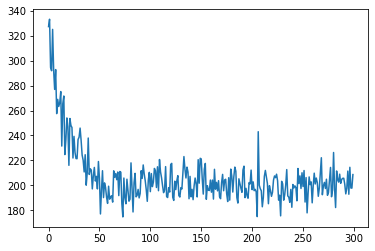

In [10]:
plt.plot(losses[:])

In [11]:
 torchsde.sdeint(sde, Θ_0, ts, method="euler", dt=Δt).shape

torch.Size([1000, 50, 6])

In [12]:
X_train.shape

torch.Size([80, 2])

In [13]:
Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

In [14]:
Θ_1 = Θ_1.reshape(50,K,2)

(array([10., 16., 17.,  9., 12., 20., 28., 23., 12.,  3.]),
 array([-1.7719189 , -1.4087687 , -1.0456184 , -0.6824682 , -0.31931794,
         0.0438323 ,  0.40698254,  0.7701328 ,  1.133283  ,  1.4964333 ,
         1.8595835 ], dtype=float32),
 <a list of 10 Patch objects>)

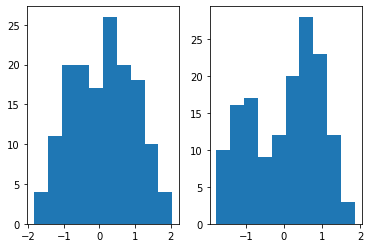

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.hist(Θ_1[:,:,0].flatten().cpu().detach().numpy())
ax2.hist(Θ_1[:,:,1].flatten().cpu().detach().numpy())

In [16]:
Θ_1.mean(axis=0).reshape(K,2)

tensor([[-0.8153, -1.0002],
        [ 0.6387,  0.5730],
        [ 0.4381,  0.6171]], device='cuda:0', grad_fn=<ViewBackward>)

In [17]:
Θ_1.shape

torch.Size([50, 3, 2])

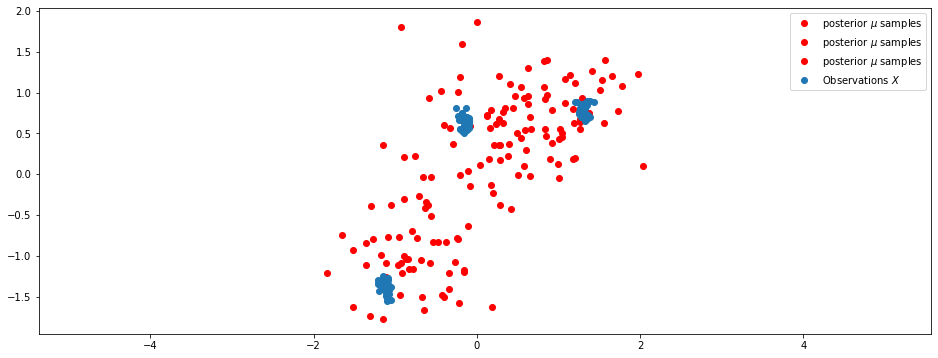

In [18]:
fig, ax_1 = plt.subplots(1, 1, figsize=(16, 6))
Θ_plot = Θ_1.cpu().detach() #.reshape(50*3,2)


for i in range(K):
    ax_1.plot(Θ_plot[:,i, 0], Θ_plot[:, i, 1], 
             linestyle='none', 
             marker='o', color="red", label="posterior $\mu$ samples")

ax_1.plot(X_scaled[:, 0], X_scaled[:, 1], 
         linestyle='none', 
         marker='o', label="Observations $X$")

ax_1.legend()
ax_1.axis('equal');